**ส่วนนี้คือการ load ข้อมูล, และการกำจัด outliers (ท่านสามารถดูเพิ่มเติมได้ที่ 1_Data_Cleaning.ipynb)**

**สำหรับ Logistic Regression จะเริ่มต่อท้ายหลังจบส่วนนี้**

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# disable warnings that are not critical for a clean looking
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('./dataset/Churn_Modelling.csv')

In [5]:
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

#### การกำจัด outliers

In [6]:
def my_func(feature, upper, lower):
    tmp = df[(df[feature] >= upper) | (df[feature] <= lower)]
    df.drop(index=tmp.index, inplace=True)

In [7]:
my_func('CreditScore',None,383)
my_func('Age',62,None)

**Logistic Regression จะเริ่มต้นขึ้นต่อจากนี้**

---

#### การสร้าง dummy variables

สร้าง dummy variables โดย drop_first ด้วย เพื่อป้องกันปัญหา multi-collinearity (การมีสหสัมพันธ์กันเองระหว่างตัวแปรอิสระ) ซึ่งจะทำให้ model มีความคลาดเคลื่อนได้:

In [8]:
df_new = pd.get_dummies(df, drop_first=True)

In [9]:
df_new.columns.values

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male'],
      dtype=object)

#### ทำการแบ่งข้อมูล train/test ด้วยอัตราส่วน 80:20

ทำการแบ่งข้อมูลเป็นสองชุด ได้แก่

1) Training Set เพื่อใช้ฝึกสอน model
2) Test Set เพื่อใช้ประเมิน model

นั่นคือ จะใช้ข้อมูลชุด Training Set ในขณะฝึกสอน model และ model จะไม่เคยเห็นข้อมูลชุด Test Set มาก่อน นี่ทำให้เราสามารถประเมิน model ได้อิงกับความเป็นจริงมากกว่า

In [10]:
X = df_new.drop('Exited', axis=1)
y = df_new['Exited']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

#### Data Scaling (Standardisation)

Data scaling คือการทำให้ช่วง (scale) ของข้อมูลอยู่ในช่วงที่ใกล้เคียงกัน

บางตัวมีช่วง (scale) ที่ห่างกันมาก ซึ่งทำให้อัลกิริทึมเกิดความเอนเอียง (bias) ได้หากไม่ทำ Data Scaling นอกจากนี้ยังช่วยให้กระบวนการทำซ้ำ (iteration) ของอัลกอริทึมเข้าสู่สภาวะเสถียร (converge) ได้เร็วขึ้นด้วย

- สำหรับ KNN, SVM การทำ data scaling ช่วยให้ models สามารถวัดระยะห่าง (Euclidean distances) ของจุดข้อมูลได้ง่าย เนื่องจากข้อมูลมีช่วง (scale) ใกล้กัน ทำให้โมเดลสามารถปรับเข้าสู่จุดข้อมูล (fit) ได้ง่ายขึ้น และทำให้ความแม่นยำสูงขึ้น

- สำหรับอัลกอริทึมตระกูล tree-based ไม่จำเป็นต้องทำ data scaling

สำหรับชุดข้อมูลนี้ ได้เลือกทำ data scaling แบบ standardisation เพราะข้อมูลมีการแจกแจงใกล้เคียงการแจกแจงแบบปกติ (normal distribution) และสามารถรับมือกับข้อมูลที่มีค่าสูงหรือต่ำกว่าได้ดีกว่า data scaling แบบ normalisation เนื่องจากตัวแปร CreditScore กับ Balance มีบางจุดข้อมูลที่มีค่าโดดออกมาจากจุดข้อมูลส่วนใหญ่ ดังนี้:

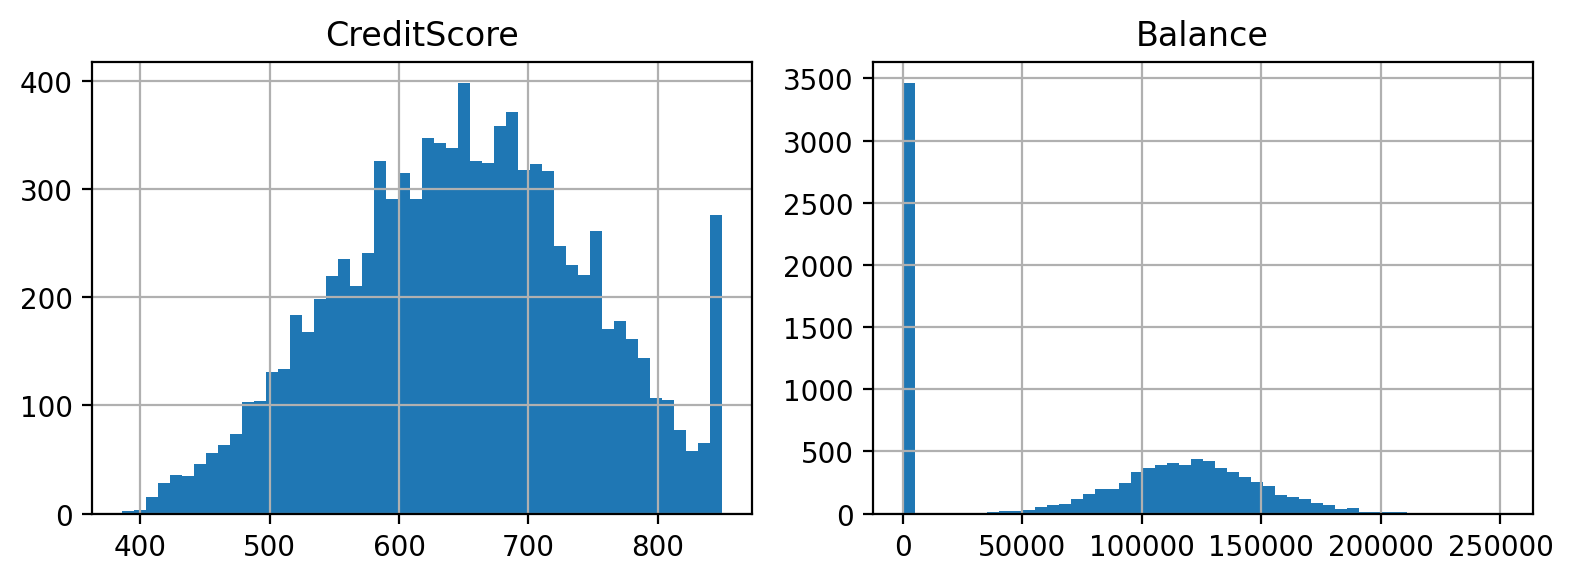

In [12]:
df[['CreditScore','Balance']].hist(bins=50, figsize=(8,3))
plt.tight_layout()

- CreditScore: กลุ่มลูกค้าที่รักษา Credit Score ให้สูง ๆ จนเกือบเต็มถึงเต็ม
- Balance: กลุ่มลูกค้าที่ยอดเงินในบัญชีมี 0 EUR

ไม่จำเป็นต้องทำ Data Scaling กับ y (ค่าเช่า) หรือ target (ค่าที่ต้องการทำนาย)

การทำ Data Scaling มีจุดประสงค์เพื่อให้แต่ละจุดข้อมูลมี scale ที่ใกล้กัน เมื่อทำการ fit model กับ X (ตัวแปรอิสระ) ตัวอัลกอริทึมจะได้วัดระยะห่างของแต่ละจุดข้อมูลได้ง่าย ส่วน y หรือ target นี้ เป็นค่าที่ต้องการทำนายออกมา จึงไม่มีปัญหาด้าน scaling

In [13]:
from sklearn.preprocessing import StandardScaler

sc_X_train = StandardScaler()
sc_X_test = StandardScaler()

In [14]:
tmp = X_train
std = sc_X_train.fit_transform(tmp)
X_train = pd.DataFrame(std, columns=tmp.columns)

tmp = X_test
std = sc_X_test.fit_transform(tmp)
X_test = pd.DataFrame(std, columns=tmp.columns)

#### เขียนฟังก์ชั่นสำหรับประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [16]:
acc = {}; f1 = {}; prec = {}; recl = {}

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    # declair as a global model to ratain the evalutation values along the notebook
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    #display(df_model_compare)

# Logistic Regression

ใช้ Sigmoid function เปลี่ยน linear ให้เป็น S-shaped curve ให้อยู่ในช่วง [0,1] เพื่อทำนายผลสองประเภท (binary class)

สร้าง (ฝึกสอน) model:

In [17]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(random_state=55)

In [18]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(random_state=55)

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [19]:
# Save Model
joblib.dump(logistic_regression, './models/Logit.pkl')

# Load Model
#logistic_regression = joblib.load('./models/Logit.pkl')

['./models/Logit.pkl']

## การประเมิน model ที่ใช้ทำนาย

ใช้โมเดลทำนาย test set:

In [20]:
logistic_predicted = logistic_regression.predict(X_test)

In [21]:
confusion_matrix(y_test, logistic_predicted)

array([[1469,   37],
       [ 292,  117]], dtype=int64)

[ TN FP ]  
[ FN TP ]

TP (ทำนายว่า churn; ความจริงคือ churn)  
TN (ทำนายว่า non-churn; ความจริงคือ non-churn)  
FP (ทำนายว่า churn; ความจริงคือ non-churn)  
FN (ทำนายว่า non-churn; ความจริงคือ churn)

Churn = เลิกใช้ธนาคาร  
Non-churn = ไม่เลิกใช้ธนาคาร

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [22]:
my_eval('Logit',y_test,logistic_predicted)

Logit Results
Accuracy:  0.8281984334203656
F1 Score:  0.4156305506216696
Precision:  0.7597402597402597
Recall:  0.2860635696821516


---

บันทึกค่าประเมินประสิทธิภาพของแต่ละ model เพื่อใช้เปรียบเทียบใน notebook ชื่อ 9_Comparison.ipynb:

In [23]:
df_model_compare.to_csv('./eval_results/eval_results_Logit.csv')